In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from torch_geometric.data import DataLoader, Dataset, Data
import lightning.pytorch as pl
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm
import torch
import itertools
import yaml
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
from torch_geometric.utils import to_scipy_sparse_matrix
import scipy.sparse as sps
import xxhash
from torch_cluster import knn

from epic_clustering.utils import plot_clusters, get_cluster_pos
from epic_clustering.models import MemberClassification
from epic_clustering.scoring import weighted_v_score

## 1. Load Model and Test Dataloading

In [ ]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
num_events = 20000
csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')][:num_events//1000 + 1]
events = pd.concat([pd.read_csv(f) for f in tqdm(sorted(csv_files))])
if num_events is not None:
    events = events[events["event"].isin(sorted(events["event"].unique())[:num_events])]

In [ ]:
events['clusterID'] = events['clusterID'].astype(np.uint64)

In [ ]:
events_list = list(events.groupby('event'))

In [ ]:
event = events_list[0][1]

In [ ]:
event

In [ ]:
event.clusterID

In [ ]:
event = event.reset_index(drop=True)
event_id = event.event[0]
event = event.drop(columns=['event'])

clusterID = torch.from_numpy(event.clusterID.to_numpy().astype(np.int64))
print(event_id)

In [ ]:
events = pd.read_csv(csv_files[0])
event = events[events["event"] == events["event"].unique()[0]]

In [ ]:
event

In [ ]:
# Sorted event.E - get first 40
high_energy_hits = event.sort_values(by="E", ascending=False).iloc[:40]

In [ ]:
# use torch meshgrid to get all pairs between high_energy_hits.hit_number and event.hit_number
pairs = torch.meshgrid(torch.from_numpy(high_energy_hits.hit_number.values), torch.from_numpy(event.hit_number.values))
# convert into a 2 x N array
pairs = torch.stack(pairs).reshape(2, -1).T

In [ ]:
dataset = EventDataset(input_dir, num_events=100)

In [ ]:
# Split dataset into train val and test
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

## 3. Training Loop Test

In [148]:
with open("member_classification.yaml") as f:
    member_classification_config = yaml.safe_load(f)
model = MemberClassification(member_classification_config)
model.setup(stage="fit")

Converting to PyG data objects


100%|██████████| 2020/2020 [00:04<00:00, 416.77it/s]

Loaded 2000 training events, 10 validation events and 10 testing events


In [ ]:
logger = WandbLogger(project=member_classification_config["project"])
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=300, logger=logger)
trainer.fit(model)

## Training Debug

In [3]:
event = model.trainset[0]

In [4]:
event

Data(x=[1600, 12], edge_index=[2, 1600], y=[1600], event_id=0, num_nodes=1600)

In [ ]:
trues, preds, true_positives = [], [], []
for event in tqdm(model.trainset):
    # Get trues, positives and true positives
    true = event.y.bool().cpu().detach().numpy()
    pred = torch.ones(len(true)).bool().numpy()
    true_positives.append(np.sum(true.squeeze() & pred.squeeze()))
    trues.append(event.y.bool().cpu().detach().numpy().sum())
    preds.append(torch.ones(len(true)).bool().numpy().sum())
trues, preds, true_positives = np.sum(trues), np.sum(preds), np.sum(true_positives)

In [ ]:
true_positives / trues, true_positives / preds

In [ ]:
trues, preds, true_positives = [], [], []
for event in tqdm(model.trainset):
    # Get trues, positives and true positives
    true = event.y.bool().cpu().detach().numpy()
    pred = torch.zeros(len(true)).bool().numpy()
    true_positives.append(np.sum(true.squeeze() & pred.squeeze()))
    trues.append(event.y.bool().cpu().detach().numpy().sum())
    preds.append(torch.ones(len(true)).bool().numpy().sum())
trues, preds, true_positives = np.sum(trues), np.sum(preds), np.sum(true_positives)

In [ ]:
true_positives / trues, true_positives / preds

In [ ]:
trues, preds, true_positives = [], [], []
for event in tqdm(model.trainset):
    # Get trues, positives and true positives
    true = event.y.bool().cpu().detach().numpy()
    pred = (torch.rand(len(true)) > 0.5).bool().numpy()
    true_positives.append(np.sum(true.squeeze() & pred.squeeze()))
    trues.append(event.y.bool().cpu().detach().numpy().sum())
    preds.append(torch.ones(len(true)).bool().numpy().sum())
trues, preds, true_positives = np.sum(trues), np.sum(preds), np.sum(true_positives)

In [ ]:
true_positives / trues, true_positives / preds

In [ ]:
import scipy.sparse as sps

In [ ]:
from torch_geometric.utils import to_scipy_sparse_matrix
import xxhash

In [ ]:
event.edge_index.max()

In [ ]:
true_edges = event.edge_index[:, event.y.bool()]

In [ ]:
sparse_edges = to_scipy_sparse_matrix(true_edges, num_nodes = event.edge_index.max()+1)

In [ ]:
_, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
labels = torch.from_numpy(candidate_labels).long()

In [ ]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
csv_file = os.path.join(input_dir, "/global/cfs/cdirs/m3443/data/PowerWeek/train/train/train_ePIC_event27000_28000.csv")
events = pd.read_csv(csv_file)

In [ ]:
event_df = events[events.event == 27000]

In [ ]:
event_df

In [ ]:
event_df['tmp_clusterID'] = labels
# event['tmp_clusterID'] = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit_predict(event[['posx', 'posy']]/[2, 2], sample_weight=event['E'])

# encode the labels to make sure it's unique across all events 
str_ids = event_df['event'].astype('str') + "_" + event_df['tmp_clusterID'].astype('str')
event_df['labelID'] = [xxhash.xxh64_intdigest(x, seed=0) for x in str_ids.values]

In [ ]:
pd.options.mode.chained_assignment = None
for ineff in np.linspace(0.1, 0.5, 5):

    for impur in np.linspace(0.0, 0.01, 5):
    
        # Make a copy of true edges
        tainted_edges = true_edges.clone()

        # Make a random selection of edges to remove
        random_edges = torch.rand(len(tainted_edges[0])) > ineff
        tainted_edges = tainted_edges[:, random_edges]

        # Make a random permutation of edge_index, of size true_edges*impur
        random_edges = torch.randperm(len(event.edge_index[0]))[:int(len(true_edges[0])*impur)]
        tainted_edges = torch.cat([tainted_edges, event.edge_index[:, random_edges]], dim=1)

        print(f"True edges: {len(true_edges[0])}, Tainted edges: {len(tainted_edges[0])}")

        sparse_edges = to_scipy_sparse_matrix(tainted_edges, num_nodes = event.edge_index.max()+1)
        
        _, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
        labels = torch.from_numpy(candidate_labels).long()
        event_df['tmp_clusterID'] = labels
        
        # encode the labels to make sure it's unique across all events 
        str_ids = event_df['event'].astype('str') + "_" + event_df['tmp_clusterID'].astype('str')
        event_df['labelID'] = [xxhash.xxh64_intdigest(x, seed=0) for x in str_ids.values]
        print(f"Inefficiency: {ineff}, Impurity: {impur}, Vscore: {weighted_v_score(labels_true=event_df['clusterID'], labels_pred=event_df['labelID'], labels_weight=event_df['E'])[2]}")

## ClusterGrow

### The Plan

1. Start with the seeds in one tensor
2. Collect all nonseeds in another tensor
3. For each nonseed, find the closest seed with K=1 KNN
4. Convert to sparse array
5. Perform connected components

In [151]:
event = model.trainset[-1]

In [152]:
event

Data(x=[1600, 12], edge_index=[2, 1600], y=[1600], event_id=10008, num_nodes=1600)

In [141]:
true_edges = event.edge_index[:, event.y.bool()]

In [142]:
# Collect seeds in one tensor
seeds_idx = true_edges.unique()

In [6]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
csv_file = os.path.join(input_dir, "/global/cfs/cdirs/m3443/data/PowerWeek/train/train/train_ePIC_event0_1000.csv")
events_df = pd.read_csv(csv_file)

In [153]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
num_events = sum(model.hparams["data_split"])
csv_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')])[:num_events//1000 + 1]
events_df = pd.concat([pd.read_csv(f) for f in sorted(csv_files)])
if num_events is not None:
    events_df = events_df[events_df["event"].isin(sorted(events_df["event"].unique())[:num_events])]
events_df['clusterID'] = events_df['clusterID'].astype(np.uint64) # Needed for some reason?

In [154]:
event_df = events_df[events_df.event == 10008]

In [36]:
# Collect nonseeds in another tensor
nonseeds_idx = torch.from_numpy(event_df.hit_number[~np.isin(event_df.hit_number.values, seeds_idx.long().numpy())].values).unique()

In [37]:
# For each nonseed find closest seed with knn=1
nonseeds_to_seeds = knn(torch.from_numpy(event_df[np.isin(event_df.hit_number.values, seeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), torch.from_numpy(event_df[np.isin(event_df.hit_number.values, nonseeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), 1)

# Convert 0, .., N indices back to original seed_idx and nonseed_idx
nonseeds_to_seeds = torch.stack([seeds_idx[nonseeds_to_seeds[1]], nonseeds_idx[nonseeds_to_seeds[0]]])

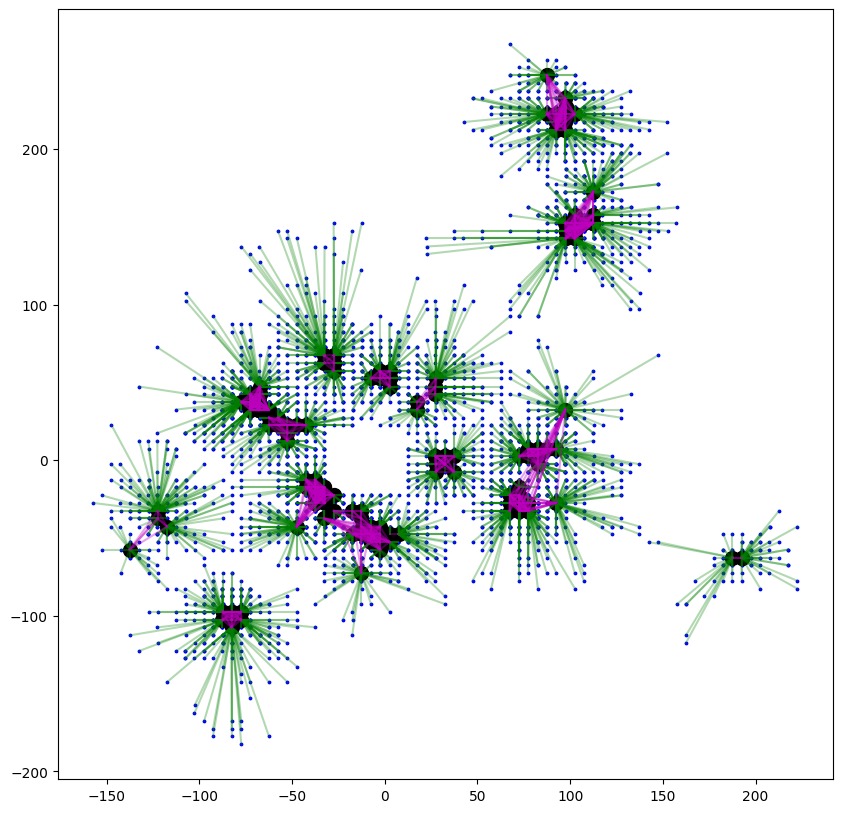

In [38]:
# Visualize this!
plt.figure(figsize=(10, 10))
seeds_df = event_df[np.isin(event_df.hit_number.values, seeds_idx.long().numpy())]
nonseeds_df = event_df[np.isin(event_df.hit_number.values, nonseeds_idx.long().numpy())]
plt.scatter(nonseeds_df.posx, nonseeds_df.posy, marker='o', c='b', s=3)
plt.plot(event_df.posx.values[nonseeds_to_seeds], event_df.posy.values[nonseeds_to_seeds], c="g", alpha=0.3)
plt.plot(event_df.posx.values[true_edges], event_df.posy.values[true_edges], c="m", alpha=0.2)
plt.scatter(seeds_df.posx, seeds_df.posy, marker='o', c='k', s=100)

In [71]:
combined_graph = torch.cat([nonseeds_to_seeds, true_edges], dim=-1)

In [72]:
sparse_edges = to_scipy_sparse_matrix(combined_graph, num_nodes = len(event_df))

In [73]:
_, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
labels = torch.from_numpy(candidate_labels).long()

### Scoring

In [157]:
np.mean([len(event.edge_index.unique()) for event in tqdm(model.trainset)])

100%|██████████| 2000/2000 [00:00<00:00, 42808.85it/s]


39.9785

In [50]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
num_events = sum(model.hparams["data_split"])
csv_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')])[:num_events//1000 + 1]
events_df = pd.concat([pd.read_csv(f) for f in sorted(csv_files)])
if num_events is not None:
    events_df = events_df[events_df["event"].isin(sorted(events_df["event"].unique())[:num_events])]
events_df['clusterID'] = events_df['clusterID'].astype(np.uint64) # Needed for some reason?

In [158]:
pd.options.mode.chained_assignment = None
def label_hits(event, events_df, max_dist=None):
    true_edges = event.edge_index[:, event.y.bool()]
    
    seeds_idx = true_edges.unique()
    
    event_df = events_df[events_df.event == event.event_id]
    
    # Collect nonseeds in another tensor
    nonseeds_idx = torch.from_numpy(event_df.hit_number[~np.isin(event_df.hit_number.values, seeds_idx.long().numpy())].values).unique()

    # For each nonseed find closest seed with knn=1
    nonseeds_to_seeds = knn(torch.from_numpy(event_df[np.isin(event_df.hit_number.values, seeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), torch.from_numpy(event_df[np.isin(event_df.hit_number.values, nonseeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), 1)

    # Convert 0, .., N indices back to original seed_idx and nonseed_idx
    nonseeds_to_seeds = torch.stack([seeds_idx[nonseeds_to_seeds[1]], nonseeds_idx[nonseeds_to_seeds[0]]])
    
    if max_dist is not None:
        positions = torch.from_numpy(events_df[["posx", "posy", "posz"]].values)
        nonseeds_to_seeds = nonseeds_to_seeds[:, torch.sqrt(torch.sum((positions[nonseeds_to_seeds[0]] - positions[nonseeds_to_seeds[1]])**2, dim=-1)) < max_dist]
    
    combined_graph = torch.cat([nonseeds_to_seeds, true_edges], dim=-1)
    sparse_edges = to_scipy_sparse_matrix(combined_graph, num_nodes = len(event_df))
    _, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
    labels = torch.from_numpy(candidate_labels).long()
    
    event_df['tmp_clusterID'] = labels

    # encode the labels to make sure it's unique across all events 
    str_ids = event_df['event'].astype('str') + "_" + event_df['tmp_clusterID'].astype('str')
    event_df['labelID'] = [xxhash.xxh64_intdigest(x, seed=0) for x in str_ids.values]
    
    return event_df

In [163]:
labelled_events_df = []
for event in tqdm(model.trainset[:2000]):
    try:
        labelled_events_df.append(label_hits(event, events_df))
    except:
        pass
labelled_events_df = pd.concat(labelled_events_df)
print(f"Vscore: {weighted_v_score(labels_true=labelled_events_df['clusterID'], labels_pred=labelled_events_df['labelID'], labels_weight=labelled_events_df['E'])[2]}")

100%|██████████| 2000/2000 [00:20<00:00, 98.54it/s] 
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Vscore: 0.9623379656722668


In [98]:
print(f"Vscore: {weighted_v_score(labels_true=labelled_events_df['clusterID'], labels_pred=labelled_events_df['labelID'], labels_weight=labelled_events_df['E'])[2]}")

/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Vscore: 0.9675761358714541


### Examine a Low Scoring Event

In [54]:
worst_performance = 0
worst_score = None
for event in tqdm(model.trainset[:100]):
    try:
        labelled_event = label_hits(event, events_df)
    except:
        pass
    score = weighted_v_score(labels_true=labelled_event['clusterID'], labels_pred=labelled_event['labelID'], labels_weight=labelled_event['E'])[2]
    performance = labelled_event.E.sum() / score
    if performance > worst_performance:
        print(performance)
        print(event)
        print(score)
        worst_performance = performance
        worst_score = score


 15%|█▌        | 15/100 [00:00<00:01, 73.37it/s]

359.5025581119124
Data(x=[35721, 12], edge_index=[2, 35721], y=[35721], event_id=0, num_nodes=35721)
0.902786426869227



 32%|███▏      | 32/100 [00:00<00:00, 76.21it/s]

410.6292304888979
Data(x=[34596, 12], edge_index=[2, 34596], y=[34596], event_id=19, num_nodes=34596)
0.9006264764843596
478.1645401651737
Data(x=[56644, 12], edge_index=[2, 56644], y=[56644], event_id=33, num_nodes=56644)
0.8982985229894392



 55%|█████▌    | 55/100 [00:00<00:00, 67.78it/s]

484.8075018006634
Data(x=[39601, 12], edge_index=[2, 39601], y=[39601], event_id=43, num_nodes=39601)
0.8674780299652215
493.5129085028617
Data(x=[52441, 12], edge_index=[2, 52441], y=[52441], event_id=55, num_nodes=52441)
0.8718887775791684



 69%|██████▉   | 69/100 [00:01<00:00, 65.78it/s]

573.7543180780083
Data(x=[58081, 12], edge_index=[2, 58081], y=[58081], event_id=61, num_nodes=58081)
0.842401729540597



100%|██████████| 100/100 [00:01<00:00, 67.21it/s][A


In [60]:
hard_event = model.trainset[61]
hard_event_df = events_df[events_df.event == hard_event.event_id]

In [61]:
hard_event

Data(x=[58081, 12], edge_index=[2, 58081], y=[58081], event_id=61, num_nodes=58081)

In [62]:
hard_event_df.E.sum() / worst_score

573.7543180780083

In [76]:
true_edges = hard_event.edge_index[:, hard_event.y.bool()]

In [77]:
# Collect seeds in one tensor
seeds_idx = true_edges.unique()

In [78]:
# Collect nonseeds in another tensor
nonseeds_idx = torch.from_numpy(hard_event_df.hit_number[~np.isin(hard_event_df.hit_number.values, seeds_idx.long().numpy())].values).unique()

In [79]:
# For each nonseed find closest seed with knn=1
nonseeds_to_seeds = knn(torch.from_numpy(hard_event_df[np.isin(hard_event_df.hit_number.values, seeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), torch.from_numpy(hard_event_df[np.isin(hard_event_df.hit_number.values, nonseeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), 1)

# Convert 0, .., N indices back to original seed_idx and nonseed_idx
nonseeds_to_seeds = torch.stack([seeds_idx[nonseeds_to_seeds[1]], nonseeds_idx[nonseeds_to_seeds[0]]])

In [80]:
cluster_id = hard_event_df.clusterID.values

In [83]:
true_neighbor_edges = nonseeds_to_seeds[:, cluster_id[nonseeds_to_seeds[0]] == cluster_id[nonseeds_to_seeds[1]]]
fake_neighbor_edges = nonseeds_to_seeds[:, cluster_id[nonseeds_to_seeds[0]] != cluster_id[nonseeds_to_seeds[1]]]

 20%|█▉        | 220/1110 [04:19<17:28,  1.18s/it]


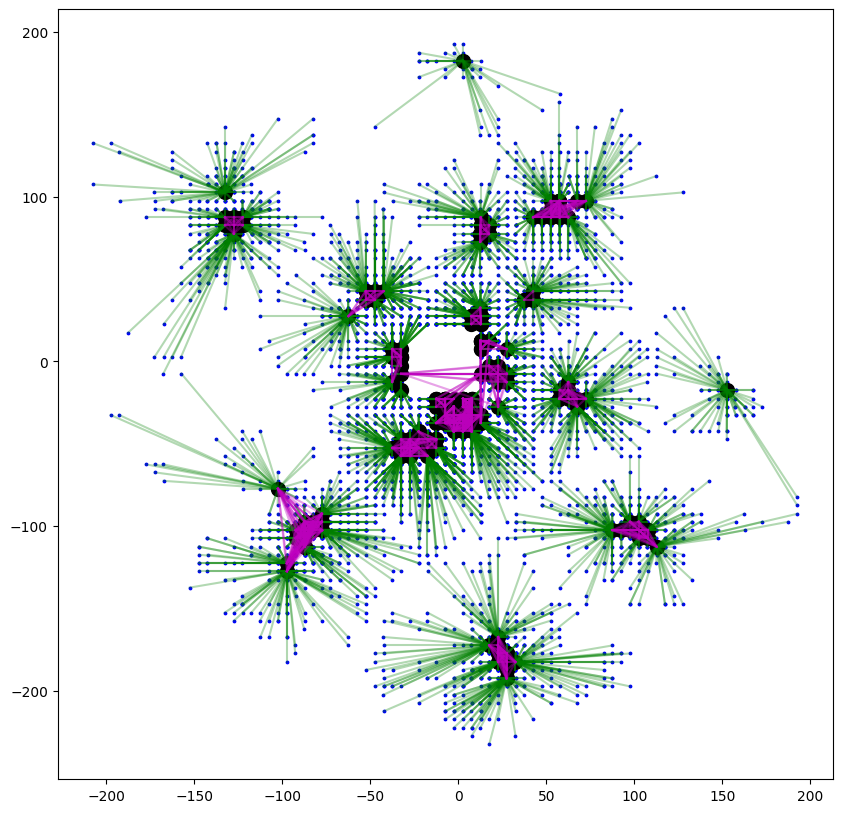

In [69]:
# Visualize this!
plt.figure(figsize=(10, 10))
seeds_df = hard_event_df[np.isin(hard_event_df.hit_number.values, seeds_idx.long().numpy())]
nonseeds_df = hard_event_df[np.isin(hard_event_df.hit_number.values, nonseeds_idx.long().numpy())]
plt.scatter(nonseeds_df.posx, nonseeds_df.posy, marker='o', c='b', s=3)
plt.plot(hard_event_df.posx.values[nonseeds_to_seeds], hard_event_df.posy.values[nonseeds_to_seeds], c="g", alpha=0.3)
plt.plot(hard_event_df.posx.values[true_edges], hard_event_df.posy.values[true_edges], c="m", alpha=0.2)
plt.scatter(seeds_df.posx, seeds_df.posy, marker='o', c='k', s=100)

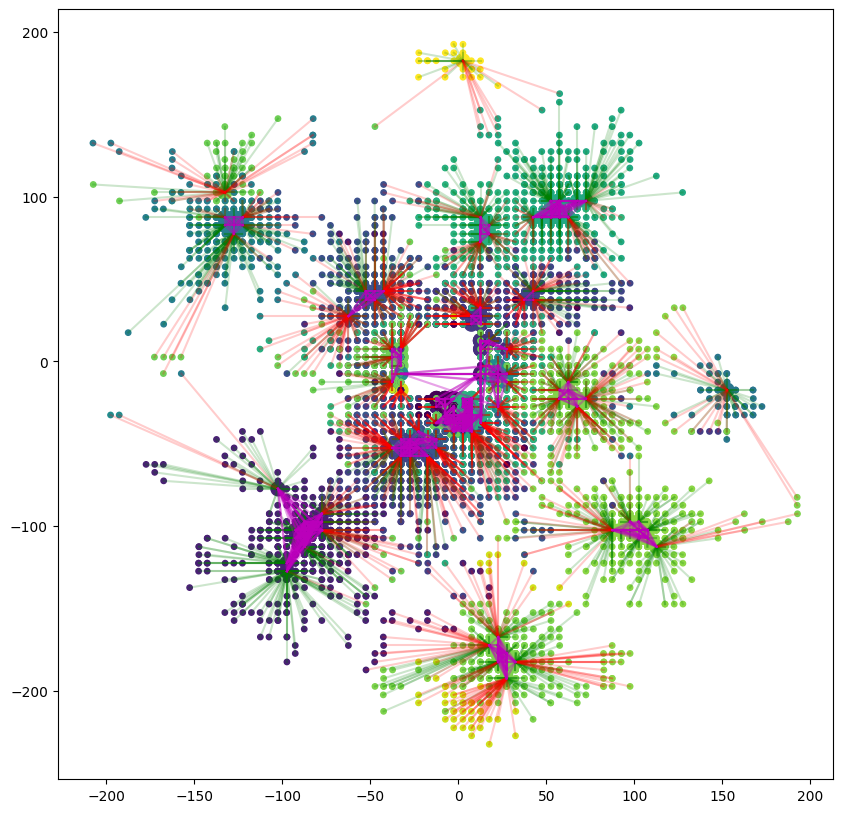

In [90]:
# Visualize this!
plt.figure(figsize=(10, 10))
seeds_df = hard_event_df[np.isin(hard_event_df.hit_number.values, seeds_idx.long().numpy())]
nonseeds_df = hard_event_df[np.isin(hard_event_df.hit_number.values, nonseeds_idx.long().numpy())]
plt.plot(hard_event_df.posx.values[true_neighbor_edges], hard_event_df.posy.values[true_neighbor_edges], c="g", alpha=0.2)
plt.plot(hard_event_df.posx.values[fake_neighbor_edges], hard_event_df.posy.values[fake_neighbor_edges], c="r", alpha=0.2)
plt.plot(hard_event_df.posx.values[true_edges], hard_event_df.posy.values[true_edges], c="m", alpha=0.2)
plt.scatter(seeds_df.posx, seeds_df.posy, marker='o', c=seeds_df.clusterID, s=100)
plt.scatter(nonseeds_df.posx, nonseeds_df.posy, marker='o', c=nonseeds_df.clusterID, s=15)

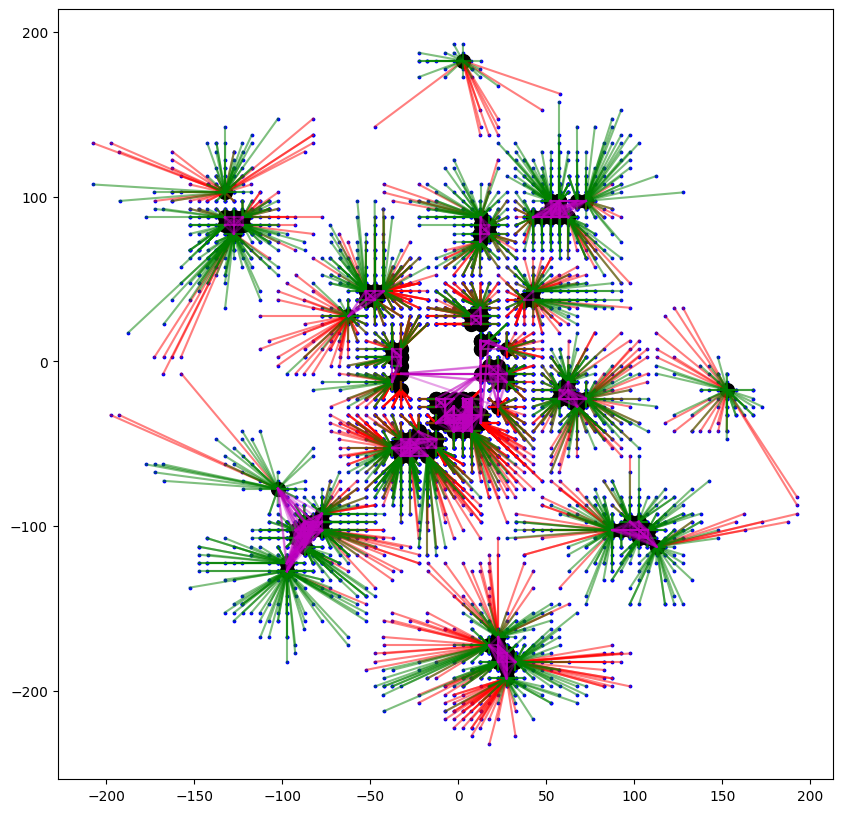

In [86]:
# Visualize this!
plt.figure(figsize=(10, 10))
seeds_df = hard_event_df[np.isin(hard_event_df.hit_number.values, seeds_idx.long().numpy())]
nonseeds_df = hard_event_df[np.isin(hard_event_df.hit_number.values, nonseeds_idx.long().numpy())]
plt.scatter(nonseeds_df.posx, nonseeds_df.posy, marker='o', c='b', s=3)
plt.plot(hard_event_df.posx.values[fake_neighbor_edges], hard_event_df.posy.values[fake_neighbor_edges], c="r", alpha=0.5)
plt.plot(hard_event_df.posx.values[true_neighbor_edges], hard_event_df.posy.values[true_neighbor_edges], c="g", alpha=0.5)
plt.plot(hard_event_df.posx.values[true_edges], hard_event_df.posy.values[true_edges], c="m", alpha=0.2)
plt.scatter(seeds_df.posx, seeds_df.posy, marker='o', c='k', s=100)

In [24]:
scores, energies, num_seeds = [], [], []
for event in tqdm(model.trainset[:1000]):
    try:
        labelled_event = label_hits(event, events_df)
    except:
        pass
    scores.append(weighted_v_score(labels_true=labelled_event['clusterID'], labels_pred=labelled_event['labelID'], labels_weight=labelled_event['E'])[2])
    energies.append(labelled_event.E.sum())
    num_seeds.append(len(event.edge_index.unique()))

100%|██████████| 1000/1000 [00:09<00:00, 106.42it/s]


/tmp/ipykernel_340689/1152078282.py:1: RuntimeWarning: divide by zero encountered in divide
  sns.histplot(np.array(energies) / np.array(scores))


<Axes: ylabel='Count'>

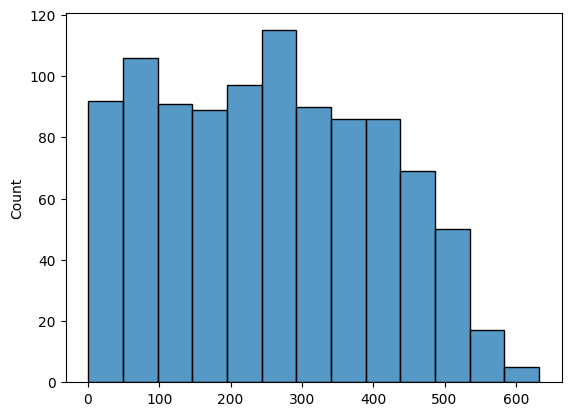

In [26]:
sns.histplot(np.array(energies) / np.array(scores))

<Axes: ylabel='Count'>

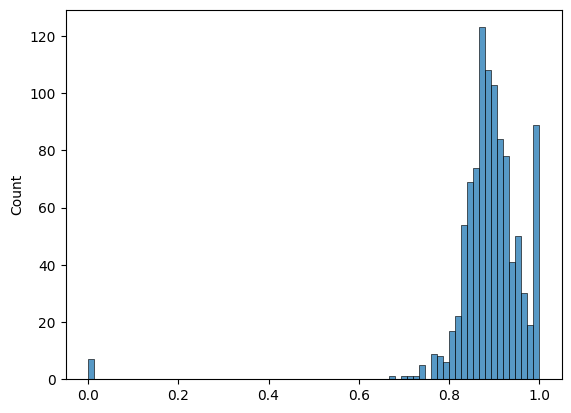

In [62]:
sns.histplot(scores)

In [63]:
np.mean(scores)

0.8908487040741018

<Axes: >

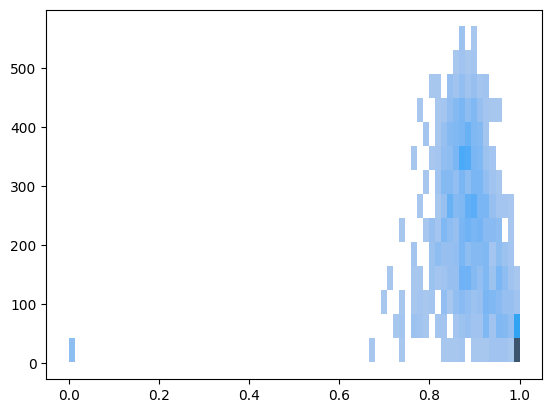

In [64]:
sns.histplot(x=scores, y=energies)

<Axes: >

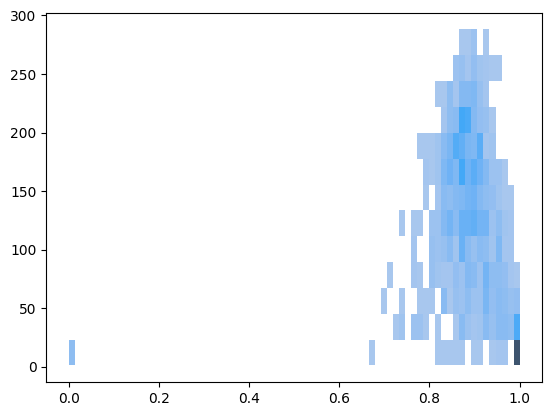

In [66]:
sns.histplot(x=scores, y=num_seeds)

<Axes: >

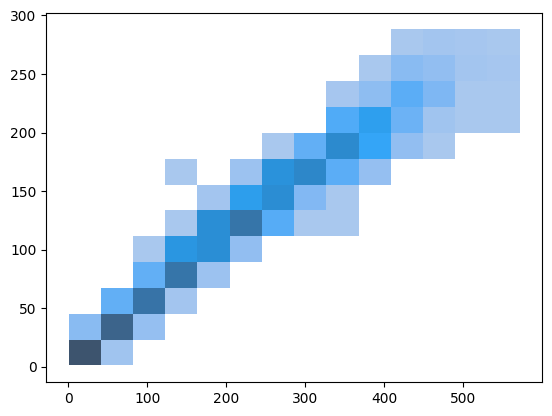

In [67]:
sns.histplot(x=energies, y=num_seeds)

## Try with Real Model!

In [2]:
checkpoint_file = "/global/cfs/cdirs/m3443/data/PowerWeek/checkpoints/classifier.ckpt"

In [24]:
model = MemberClassification.load_from_checkpoint(checkpoint_file)

In [183]:
model.hparams["data_split"] = [5000, 100, 100]

In [184]:
model.setup(stage="fit")

Converting to PyG data objects


100%|██████████| 5200/5200 [00:09<00:00, 524.83it/s]

Loaded 5000 training events, 100 validation events and 100 testing events


In [185]:
model.hparams

"activation":       ReLU
"batch_size":       20
"checkpoint_dir":   /global/cfs/cdirs/m3443/data/PowerWeek/checkpoints/
"data_split":       [5000, 100, 100]
"emb_hidden":       1024
"energy_weighting": True
"factor":           0.7
"input_dir":        /global/cfs/cdirs/m3443/data/PowerWeek/train/train/
"input_features":   12
"lr":               0.01
"max_epochs":       10
"nb_layer":         4
"patience":         30
"project":          PowerWeek_MemberClassification
"warmup":           10

In [186]:
model.trainset[0]

Data(x=[1600, 12], edge_index=[2, 1600], y=[1600], event_id=0, num_nodes=1600)

In [187]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
num_events = sum(model.hparams["data_split"])
csv_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')])[:num_events//1000 + 1]
events_df = pd.concat([pd.read_csv(f) for f in sorted(csv_files)])
if num_events is not None:
    events_df = events_df[events_df["event"].isin(sorted(events_df["event"].unique())[:num_events])]
events_df['clusterID'] = events_df['clusterID'].astype(np.uint64) # Needed for some reason?

In [188]:
len(events_df.event.unique())

5200

In [189]:
event = model.trainset[0]
event_df = events_df[events_df.event == event.event_id]

In [190]:
with torch.no_grad():
    edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()

In [191]:
edge_scores

tensor([9.9998e-01, 6.8248e-06, 6.5850e-06,  ..., 1.6075e-06, 1.5813e-04,
        9.9942e-01])

In [17]:
pd.options.mode.chained_assignment = None
def label_hits(event, events_df, pred_edges, max_dist=None):
    
    seeds_idx = pred_edges.unique()
    
    event_df = events_df[events_df.event == event.event_id]
    
    # Collect nonseeds in another tensor
    nonseeds_idx = torch.from_numpy(event_df.hit_number[~np.isin(event_df.hit_number.values, seeds_idx.long().numpy())].values).unique()

    # For each nonseed find closest seed with knn=1
    nonseeds_to_seeds = knn(torch.from_numpy(event_df[np.isin(event_df.hit_number.values, seeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), torch.from_numpy(event_df[np.isin(event_df.hit_number.values, nonseeds_idx.long().numpy())][['posx', 'posy']].to_numpy()), 1)

    # Convert 0, .., N indices back to original seed_idx and nonseed_idx
    nonseeds_to_seeds = torch.stack([seeds_idx[nonseeds_to_seeds[1]], nonseeds_idx[nonseeds_to_seeds[0]]])
    
    if max_dist is not None:
        positions = torch.from_numpy(events_df[["posx", "posy", "posz"]].values)
        nonseeds_to_seeds = nonseeds_to_seeds[:, torch.sqrt(torch.sum((positions[nonseeds_to_seeds[0]] - positions[nonseeds_to_seeds[1]])**2, dim=-1)) < max_dist]
    
    combined_graph = torch.cat([nonseeds_to_seeds, pred_edges], dim=-1)
    sparse_edges = to_scipy_sparse_matrix(combined_graph, num_nodes = len(event_df))
    _, candidate_labels = sps.csgraph.connected_components(sparse_edges, directed=False, return_labels=True)  
    labels = torch.from_numpy(candidate_labels).long()
    
    event_df['tmp_clusterID'] = labels

    # encode the labels to make sure it's unique across all events 
    str_ids = event_df['event'].astype('str') + "_" + event_df['tmp_clusterID'].astype('str')
    event_df['labelID'] = [xxhash.xxh64_intdigest(x, seed=0) for x in str_ids.values]
    
    return event_df

In [192]:
event.edge_index.shape

torch.Size([2, 1600])

In [193]:
edge_scores.shape

torch.Size([1600])

In [194]:
labelled_event_df = label_hits(event, events_df, event.edge_index[:, edge_scores > 0.5])

In [195]:
print(f"Vscore: {weighted_v_score(labels_true=labelled_event_df['clusterID'], labels_pred=labelled_event_df['labelID'], labels_weight=labelled_event_df['E'])[2]}")

Vscore: 0.8809764334392161


100%|██████████| 1000/1000 [00:21<00:00, 46.55it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Cut: 0.6, Vscore: 0.9584153668745209, mean score: 0.8384434056669355


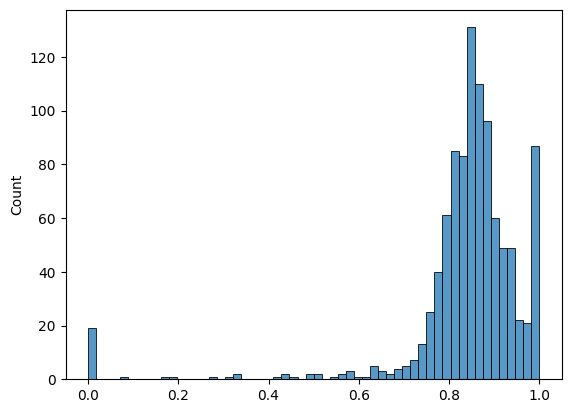

100%|██████████| 1000/1000 [00:23<00:00, 42.38it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Cut: 0.6333333333333333, Vscore: 0.9584324922971744, mean score: 0.8404377776088767


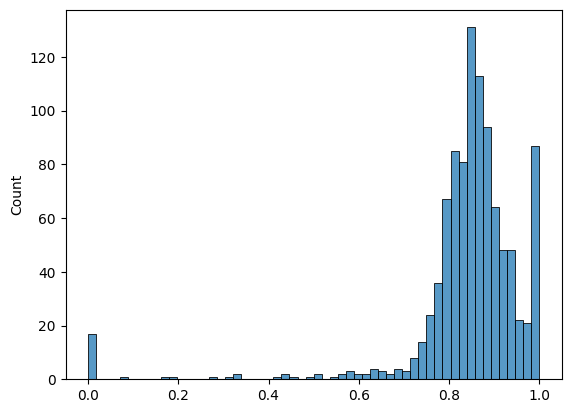

100%|██████████| 1000/1000 [00:22<00:00, 44.07it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Cut: 0.6666666666666666, Vscore: 0.9584083524274382, mean score: 0.8422767804932062


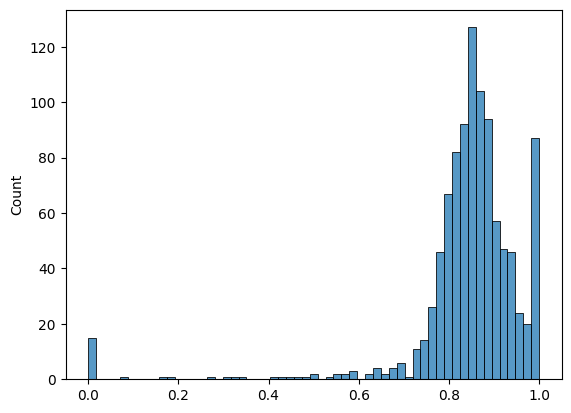

100%|██████████| 1000/1000 [00:22<00:00, 44.68it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Cut: 0.7, Vscore: 0.9583802208292752, mean score: 0.8447846044945769


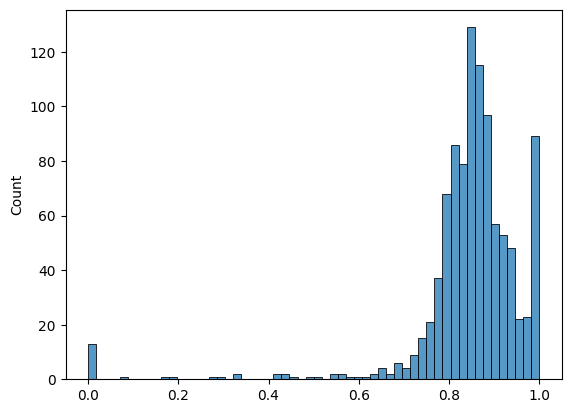

100%|██████████| 1000/1000 [00:22<00:00, 43.97it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Cut: 0.7333333333333334, Vscore: 0.9582952093981313, mean score: 0.8461919292599609


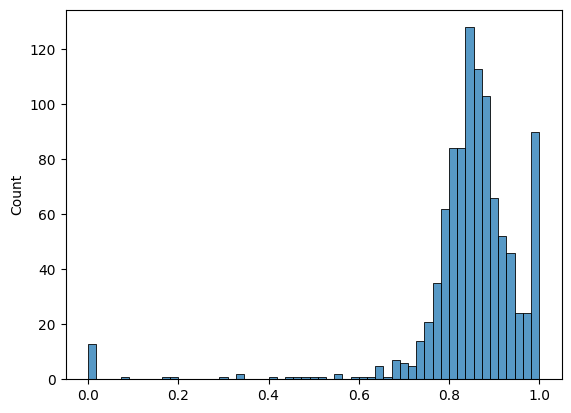

100%|██████████| 1000/1000 [00:23<00:00, 43.22it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Cut: 0.7666666666666666, Vscore: 0.9581386855068172, mean score: 0.8475034257732312


In [ ]:
for cut in np.linspace(0.6, 0.9, 10):
    labelled_events_df, scores = [], []
    for event in tqdm(model.trainset[:1000]):
        try:
            with torch.no_grad():
                edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()
            labelled_event_df = label_hits(event, events_df, event.edge_index[:, edge_scores > cut])
            labelled_events_df.append(labelled_event_df)
            scores.append(weighted_v_score(labels_true=labelled_event_df['clusterID'], labels_pred=labelled_event_df['labelID'], labels_weight=labelled_event_df['E'])[2])
        except:
            pass
    labelled_events_df = pd.concat(labelled_events_df)
    print(f"Cut: {cut}, Vscore: {weighted_v_score(labels_true=labelled_events_df['clusterID'], labels_pred=labelled_events_df['labelID'], labels_weight=labelled_events_df['E'])[2]}, mean score: {np.mean(scores)}")
    sns.histplot(scores)
    plt.show()

In [180]:
labelled_events_df = []
for event in tqdm(model.trainset):
    try:
        with torch.no_grad():
            edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()
        labelled_events_df.append(label_hits(event, events_df, event.edge_index[:, edge_scores > 0.5]))
    except:
        pass
labelled_events_df = pd.concat(labelled_events_df)
print(f"Vscore: {weighted_v_score(labels_true=labelled_events_df['clusterID'], labels_pred=labelled_events_df['labelID'], labels_weight=labelled_events_df['E'])[2]}")

100%|██████████| 5000/5000 [01:43<00:00, 48.53it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Vscore: 0.9654392191807881


In [196]:
labelled_events_df = []
for event in tqdm(model.trainset):
    try:
        with torch.no_grad():
            edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()
        labelled_events_df.append(label_hits(event, events_df, event.edge_index[:, edge_scores > 0.5]))
    except:
        pass
labelled_events_df = pd.concat(labelled_events_df)
print(f"Vscore: {weighted_v_score(labels_true=labelled_events_df['clusterID'], labels_pred=labelled_events_df['labelID'], labels_weight=labelled_events_df['E'])[2]}")

100%|██████████| 5000/5000 [01:45<00:00, 47.25it/s]
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Vscore: 0.9652404643101388


### Test Dataset

In [25]:
model.hparams["data_split"] = [10000, 0, 0]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/PowerWeek/test/test"

In [26]:
model.setup(stage="fit")

Converting to PyG data objects


100%|██████████| 9960/9960 [00:20<00:00, 486.91it/s]

Loaded 9960 training events, 0 validation events and 0 testing events


In [27]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/test/test"
num_events = sum(model.hparams["data_split"])
csv_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')])[:num_events//1000 + 1]
events_df = pd.concat([pd.read_csv(f) for f in tqdm(sorted(csv_files))])
if num_events is not None:
    events_df = events_df[events_df["event"].isin(sorted(events_df["event"].unique())[:num_events])]

100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


In [28]:
labelled_events_df = []
for event in tqdm(model.trainset):
    try:
        with torch.no_grad():
            edge_scores = model.cuda()(event.x.cuda()).cpu().squeeze()
        labelled_events_df.append(label_hits(event, events_df, event.edge_index[:, edge_scores > 0.65]))
    except:
        print(f"Error with event {event}")
labelled_events_df = pd.concat(labelled_events_df)

 46%|████▌     | 4548/9960 [01:48<01:54, 47.11it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=94566, num_nodes=1)


 48%|████▊     | 4738/9960 [01:52<01:59, 43.65it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=94756, num_nodes=1)


 67%|██████▋   | 6681/9960 [02:36<01:15, 43.52it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=96703, num_nodes=1)


 69%|██████▊   | 6841/9960 [02:40<01:05, 47.63it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=96862, num_nodes=1)


 75%|███████▌  | 7519/9960 [02:57<00:56, 43.04it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=97543, num_nodes=1)


 78%|███████▊  | 7722/9960 [03:01<00:47, 47.07it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=97743, num_nodes=1)


 96%|█████████▌| 9584/9960 [03:43<00:08, 45.89it/s]

Error with event Data(x=[1, 12], edge_index=[2, 1], event_id=99616, num_nodes=1)


100%|██████████| 9960/9960 [03:51<00:00, 43.03it/s]


In [38]:
missing_rows = events_df[~events_df.uniqueID.isin(labelled_events_df.uniqueID)]

In [40]:
missing_rows['labelID'] = np.random.randint(0, 1000000, (len(missing_rows)))

In [41]:
labelled_events_df = pd.concat([labelled_events_df, missing_rows])

In [42]:
labelled_events_df

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,uniqueID,tmp_clusterID,labelID,clusterID
0,90000,0,2257,1.755586,15.13,63,53,5,12.62984,-17.425,457.27997,-3777654040436534427,0.0,1.466909e+19,1.466909e+19
1,90000,1,2257,1.158431,15.75,63,53,6,12.62984,-17.425,489.27997,9054684738012045242,0.0,1.466909e+19,1.466909e+19
2,90000,2,2257,0.995533,15.14,63,52,5,12.62984,-12.575,457.27997,-2333264911986420630,0.0,1.466909e+19,1.466909e+19
3,90000,3,2257,0.578184,18.26,61,59,4,12.58656,12.575,441.27997,1781637954554617950,1.0,9.054685e+18,9.054685e+18
4,90000,4,2257,0.450340,16.18,62,53,6,17.54328,-17.425,489.27997,-9183531888203109048,0.0,1.466909e+19,1.466909e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753457,96703,0,1,0.044539,15.17,68,108,0,67.37016,267.425,363.28000,-331071946077104300,NaN,1.367350e+05,NaN
2115337,96862,0,1,0.077531,16.28,61,50,6,2.62984,-22.575,489.27997,2330657224189355401,NaN,4.033970e+05,NaN
1322439,97543,0,1,0.039178,14.93,55,5,0,-27.37016,-257.425,361.28000,-4024270425849649432,NaN,7.757960e+05,NaN
1852606,97743,0,1,0.134030,20.76,60,54,0,17.41344,-2.575,363.28000,5529383594065266093,NaN,2.432430e+05,NaN


In [43]:
labelled_events_df["clusterID"] = labelled_events_df["labelID"]

In [44]:
labelled_events_df[["uniqueID", "clusterID"]].to_parquet("membership_classification.parquet")

In [33]:
labelled_events_df[["uniqueID", "clusterID"]].to_csv("membership_classification.csv")